<a href="https://colab.research.google.com/github/alexk2206/Data_Driven_Fantasy_Football/blob/dev/MIP_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Block 1 - Setup & Datenquellen


In [1]:
import pandas as pd
import numpy as np
import random
# !pip install rapidfuzz
from rapidfuzz import process
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.6 MB/s eta 0:00:00


In [2]:
# Konfiguration
year = 2024
num_teams = 12
num_rounds = 15
num_weeks = 17
lineup_req = {'QB': 1, 'RB': 2, 'WR': 2, 'TE': 1, 'FLEX': 1, 'K': 1, 'DST': 1}
allowed_positions = set(lineup_req.keys()) - {'FLEX'}

# Bye Weeks laden
bye_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/bye_weeks/bye_weeks_{year}.csv'
bye_weeks = pd.read_csv(bye_url)

# ADP und Projections laden
adp_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/pre_season_data/adp_projections_{year}.csv'
player_adp = (
    pd.read_csv(adp_url)
      .rename(columns={'player': 'Player', 'team': 'NFL_Team', 'position': 'POS', 'adp': 'ADP', 'points': 'TTL'})
      .fillna({'ADP': 999})
      .loc[:, ['Player', 'NFL_Team','POS', 'ADP', 'TTL']]
      .merge(bye_weeks[['Abbreviation', 'Bye']], left_on='NFL_Team', right_on='Abbreviation', how='left')
      .drop(columns='Abbreviation')
      .sort_values(by=['ADP', 'TTL'], ascending=[True, False])
      .drop_duplicates(subset='Player', keep='first')
      .dropna(subset=['Player'])
      .reset_index(drop=True)
)
player_adp['Rank'] = player_adp.index + 1

# Pre-Season Projections erstellen
season_projections = player_adp.copy()
season_projections['avg_proj'] = season_projections['TTL'] / np.where(
    season_projections['Bye'].isna(),
    num_weeks,
    num_weeks - 1
)
week_cols = [f'Week_{w}' for w in range(1, num_weeks + 1)]
for week in week_cols:
    season_projections[week] = np.where(
        season_projections['Bye'] == week,
        0,
        season_projections['avg_proj']
    )
season_projections = season_projections.drop(columns='avg_proj')

# Real Projections laden
real_projections_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/real_projections/real_projections_{year}.csv'
real_projections = (
    pd.read_csv(real_projections_url)
      .rename(columns={'player': 'Player', 'position': 'POS', 'points': 'Projection', 'week': 'Week'})
      .loc[:, ['Player', 'POS', 'Projection', 'Week']]
      .pivot_table(index=['Player', 'POS'], columns='Week', values='Projection', aggfunc='first')
      .add_prefix('Week_')
      .reset_index()
      .fillna(0)
      .drop_duplicates(subset='Player', keep='first')
)

# Real Data (Punkte aus echten Spielen) laden
real_data_rz_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/Weekly_Data/weekly_data_{year}.csv'
real_data_fp_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/Weekly_Data/FantasyPros_Fantasy_Football_Points_PPR_{year}.csv'

real_data_rz = (
    pd.read_csv(real_data_rz_url)
      .rename(columns={'position': 'POS', 'player_display_name': 'Player'})
      .replace({'FB': 'RB'})
      .drop(columns=['season'], errors='ignore')
      .loc[lambda df: df['POS'].isin(allowed_positions)]
)

real_data_fp = (
    pd.read_csv(real_data_fp_url)
      .rename(columns={'Pos': 'POS', 'player_display_name': 'Player'})
      .replace({'-': 0, 'BYE': 0})
      .drop(columns=['#', 'Team'], errors='ignore')
      .query("POS in ['K', 'DST']")
)

real_data_fp = real_data_fp.melt(
    id_vars=['Player', 'POS'],
    value_vars=[str(w) for w in range(1, 19)],
    var_name='week',
    value_name='fantasy_points_ppr'
)
real_data_fp = real_data_fp[~real_data_fp['fantasy_points_ppr'].isin(['BYE', '-', None])].copy()
real_data_fp['fantasy_points_ppr'] = pd.to_numeric(real_data_fp['fantasy_points_ppr'])

# Spieler-Namen matchen (aus verschiedenen Datenquellen)
adp_names = player_adp['Player'].unique().tolist()
adp_pos_dict = dict(zip(player_adp['Player'], player_adp['POS']))

def match_name_with_pos(name, pos, reference_list, reference_pos_dict, cutoff=85.5):
    filtered = [p for p in reference_list if reference_pos_dict.get(p) == pos]
    result = process.extractOne(name, filtered, score_cutoff=cutoff)
    return result[0] if result else None

real_data = pd.concat([real_data_fp, real_data_rz], ignore_index=True)
real_data['Player'] = real_data.apply(
    lambda row: match_name_with_pos(row['Player'], row['POS'], adp_names, adp_pos_dict),
    axis=1
)
real_data = real_data.dropna(subset=['Player']).drop_duplicates(subset=['Player', 'POS', 'week'])

In [3]:
dropoff_w = {'QB':1.0,'RB':1.0,'WR':1.0,'TE':0.9,'K':0.4,'DST':0.3}
vor_w     = {'QB':0.8,'RB':1.0,'WR':1.0,'TE':0.8,'K':0.25,'DST':0.25}

rep_ttl = (
    season_projections
      .groupby('POS')['TTL']
      .apply(lambda s: s.nlargest(lineup_req[s.name]*num_teams)
                   .iloc[-1]
             if len(s) >= lineup_req[s.name]*num_teams else 0)
)

season_projections = (
    season_projections
      .sort_values(['POS','TTL'], ascending=[True,False])
      .assign(
          dropoff=lambda df: (
              df.groupby('POS')['TTL']
                .diff(-1)
                .fillna(0)
                .mul(df['POS'].map(dropoff_w))
          ),
          VOR=lambda df: (
              (df['TTL'] - df['POS'].map(rep_ttl))
                .clip(lower=0)
                .mul(df['POS'].map(vor_w))
          )
      )
      .fillna({'dropoff': 0, 'VOR': 0, 'ADP': 999})
      .sort_values(['ADP', 'TTL'], ascending=[True, False])
      .reset_index(drop=True)
)

# Block 2 - Funktionen definieren

In [4]:
def opponent_pick(pos, roster, available, Rk, lineup_req, topk_pct):
    remaining_players = sorted(available, key=lambda p: Rk[p])
    topk = max(1, int(len(remaining_players) * topk_pct))
    deficits = {
        j: lineup_req[j] - sum(1 for p in roster if pos[p] == j)
        for j in lineup_req if j != 'FLEX'
    }
    needed = [j for j, d in deficits.items() if d > 0]

    if needed:
        candidates = [p for p in remaining_players if pos[p] in needed]
        pool = candidates[:topk] if len(candidates) >= topk else candidates
        if pool:
            return random.choice(pool)

    return random.choice(remaining_players[:topk])

def get_best_lineup(team, week, roster_proj, lineup_req):
    week_col = f"Week_{week}"
    team_roster = roster_proj[roster_proj["Team"] == team]
    lineup = []
    used = set()
    for pos_, limit in lineup_req.items():
        if pos_ != "FLEX":
            cands = team_roster[team_roster["POS"] == pos_]
        else:
            cands = team_roster[
                (team_roster["POS"].isin(["RB", "WR", "TE"])) & (~team_roster["Player"].isin(used))
            ]
        starters = cands.sort_values(week_col, ascending=False).head(limit)
        lineup.append(starters)
        used.update(starters["Player"])
    return pd.concat(lineup)

def get_actual_points(lineup, week, real_data):
    merged = lineup.merge(real_data[real_data["week"] == week], on="Player", how="left")
    merged["fantasy_points_ppr"] = merged["fantasy_points_ppr"].fillna(0)
    return merged["fantasy_points_ppr"].sum()

def create_schedule(teams, num_weeks=14):
    schedule = []
    for week in range(num_weeks):
        matchups = []
        for i in range(len(teams)//2):
            matchups.append((teams[i], teams[-(i+1)]))
        teams = [teams[0]] + [teams[-1]] + teams[1:-1]
        schedule.append(matchups)
    return schedule

# Block 3 - Draft simulieren

In [23]:
# !pip install mip
from mip import Model, xsum, BINARY, CONTINUOUS, maximize

players = (
    season_projections[['Player', 'POS', 'ADP', 'TTL', 'dropoff', 'VOR']]
    .copy()
    .sort_values(['ADP', 'TTL'], ascending=[True, False])
    .reset_index(drop=True)
)
players['Rank'] = players.index + 1
players_list = players['Player'].dropna().tolist()

positions = {'QB', 'RB', 'WR', 'TE', 'K', 'DST', 'FLEX'}
flex_eligible = {'RB', 'WR', 'TE'}
weeks = list(range(1, num_weeks + 1))
lineup_req = {'QB': 1, 'RB': 2, 'WR': 2, 'TE': 1, 'K': 1, 'DST': 1, 'FLEX': 1}
max_req = {'QB': 2, 'RB': 999, 'WR': 999, 'TE': 2, 'K': 1, 'DST': 1}
week_cols = [col for col in season_projections.columns if col.startswith('Week_')]

pos = dict(zip(season_projections['Player'], season_projections['POS']))

season_proj_dict = {
    row['Player']: {
        **{int(w.replace("Week_", "")): row[w] for w in week_cols},
        'dropoff': row['dropoff'],
        'VOR': row['VOR']
    }
    for _, row in season_projections.iterrows()
}

beta = {t: 120.0 for t in weeks}
alpha = 0.3
lambda_0 = 1
lambda_1 = 1
lambda_2 = 2
lambda_3 = 5
lambda_4 = 1
topk_pct = 0.0025

teams = [f"Team {i+1}" for i in range(num_teams)]
DM_team = random.choice(teams)

draft_order = []
for rnd in range(num_rounds):
    order = teams if rnd % 2 == 0 else teams[::-1]
    draft_order += order

rosters = {tm: [] for tm in teams}
available = set(players_list)
draft_log = []
df_sorted = players.copy()

for pick_idx, team in enumerate(draft_order, 1):
    rank_dict = dict(zip(df_sorted['Player'], df_sorted['Rank']))
    remaining_players = sorted(available, key=lambda p: rank_dict.get(p, float('inf')))
    Rk = {p: i + 1 for i, p in enumerate(remaining_players)}
    picks_remaining = num_rounds - len(rosters[team])

    if team == DM_team:
        m = Model(sense=maximize, solver_name='CBC')

        y = {i: m.add_var(var_type=BINARY, name=f'y_{i}') for i in remaining_players}
        x = {(i, t): m.add_var(var_type=CONTINUOUS, name=f'x_{i}_{t}') for i in remaining_players for t in weeks}
        z = {t: m.add_var(var_type=BINARY, name=f'z_{t}') for t in weeks}

        m.objective = (
            lambda_0 * xsum(season_proj_dict[i][t] * x[i, t] for i in remaining_players for t in weeks)
            + lambda_1 * xsum(z[t] for t in weeks[:15])
            + lambda_2 * xsum(z[t] for t in weeks[15:])
            + lambda_3 * xsum(season_proj_dict[i]['dropoff'] * y[i] for i in remaining_players)
            - lambda_4 * xsum(season_proj_dict[i]['VOR'] * y[i] for i in remaining_players)
        )

        m += xsum(y[i] for i in remaining_players) == picks_remaining

        for pos_name, req in lineup_req.items():
            if pos_name != 'FLEX':
                already_satisfied = sum(1 for p in rosters[team] if pos[p] == pos_name)
                need = max(0, req - already_satisfied)
                m += xsum(y[i] for i in remaining_players if pos[i] == pos_name) >= need

        for t in weeks:
            for j in positions - {'FLEX'}:
                m += xsum(y[i] for i in remaining_players if pos[i] == j) <= max_req[j]
            for i in remaining_players:
                m += (
                    (x[i, t] if pos[i] in positions - {'FLEX'} else 0) +
                    (x[i, t] if pos[i] in flex_eligible else 0)
                    <= 1
                )
        for i in remaining_players:
            for t in weeks:
                m += x[i, t] <= y[i]
        for t in weeks:
            m += z[t] <= xsum(season_proj_dict[i][t] * x[i, t] for i in remaining_players) / beta[t]

        n_k = pick_idx
        for future_pick in range(pick_idx + 1, pick_idx + picks_remaining * len(teams), len(teams)):
            top_cut = int(alpha * (future_pick - n_k))
            if top_cut > 0:
                top_players = [i for i, r in Rk.items() if r <= top_cut]
                m += xsum(y[i] for i in top_players) <= ((future_pick - n_k) // len(teams))

        m.optimize()
        # print(f"\n--- DM Pick {pick_idx} ---")
        # for i in remaining_players:
        #     if y[i].x is not None and y[i].x >= 0.9:
        #         ttl = sum(season_proj_dict[i][t] for t in weeks)
        #         vor = season_proj_dict[i]['VOR']
        #         print(f"{i:25} ({pos[i]})  TTL={ttl:6.1f}   VOR={vor:6.1f}")
        chosen = [i for i in remaining_players if y[i].x is not None and y[i].x >= 0.99 and i not in rosters[team]]
        pick = min(chosen, key=lambda i: Rk[i])
    else:
        current_round = (pick_idx - 1) // num_teams + 1
        dynamic_topk_pct = min(current_round * 2 * topk_pct, 1.0)
        pick = opponent_pick(
            pos=pos,
            roster=rosters[team],
            available=available,
            Rk=Rk,
            lineup_req=lineup_req,
            topk_pct=dynamic_topk_pct
        )

    rosters[team].append(pick)
    available.remove(pick)
    draft_log.append({
        'Pick': pick_idx,
        'Team': team,
        'Player': pick,
        'Round': (pick_idx - 1) // num_teams + 1,
        'POS': pos[pick]
    })

df_draft = pd.DataFrame(draft_log)

reg_schedule = create_schedule(teams)

roster_proj = (
    df_draft
    .merge(real_projections.drop(columns="POS"), on="Player", how="left")
    .sort_values(["Team", "Pick"])
    .reset_index(drop=True)
)

results = []
for week_idx, matchups in enumerate(reg_schedule, 1):
    for team1, team2 in matchups:
        l1 = get_best_lineup(team1, week_idx, roster_proj, lineup_req)
        l2 = get_best_lineup(team2, week_idx, roster_proj, lineup_req)
        p1 = get_actual_points(l1, week_idx, real_data)
        p2 = get_actual_points(l2, week_idx, real_data)
        winner = team1 if p1 > p2 else team2 if p2 > p1 else "Unentschieden"
        results.append({"Woche": week_idx, "Sieger": winner})

df_results = pd.DataFrame(results)
wins = df_results[df_results["Sieger"] != "Unentschieden"]["Sieger"].value_counts()
record = pd.DataFrame({"Team": teams})
record["Wins"] = record["Team"].map(wins).fillna(0).astype(int)
record = record.sort_values(by=["Wins"], ascending=False).reset_index(drop=True)

dm_place = record[record["Team"] == DM_team].index[0] + 1
dm_points = sum(
    get_actual_points(get_best_lineup(DM_team, w, roster_proj, lineup_req), w, real_data)
    for w in range(1, 18)
)
champion = record.iloc[0]["Team"]


dm_roster_df = df_draft[df_draft["Team"] == DM_team].reset_index(drop=True)
print("DM-Team:", DM_team)
print("Platzierung:", dm_place)
print("Champion:", champion)
print("Punkte:", round(dm_points, 2))
display(dm_roster_df)
display(record)



DM-Team: Team 12
Platzierung: 9
Champion: Team 6
Punkte: 1514.54


,Pick,Team,Player,Round,POS
0,12,Team 12,Puka Nacua,1,WR
1,13,Team 12,Derrick Henry,2,RB
2,36,Team 12,Drake London,3,WR
3,37,Team 12,Joe Mixon,4,RB
4,60,Team 12,DK Metcalf,5,WR
5,61,Team 12,Stefon Diggs,6,WR
6,84,Team 12,Dalton Kincaid,7,TE
7,85,Team 12,DeAndre Hopkins,8,WR
8,108,Team 12,Chase Brown,9,RB
9,109,Team 12,Keon Coleman,10,WR


,Team,Wins
0,Team 6,10
1,Team 9,9
2,Team 5,8
3,Team 8,8
4,Team 10,8
5,Team 11,7
6,Team 2,7
7,Team 4,6
8,Team 12,6
9,Team 1,5


In [24]:
# !pip install mip
from mip import Model, xsum, BINARY, CONTINUOUS, maximize

def simulate_league_with_mip(seed, season_projections, real_projections, real_data, num_teams, num_rounds, num_weeks):
    # Random-Seed setzen
    random.seed(seed)
    np.random.seed(seed)

    players = (
        season_projections[['Player', 'POS', 'ADP', 'TTL', 'dropoff', 'VOR']]
        .copy()
        .sort_values(['ADP', 'TTL'], ascending=[True, False])
        .reset_index(drop=True)
    )
    players['Rank'] = players.index + 1
    players_list = players['Player'].dropna().tolist()

    positions = {'QB', 'RB', 'WR', 'TE', 'K', 'DST', 'FLEX'}
    flex_eligible = {'RB', 'WR', 'TE'}
    weeks = list(range(1, num_weeks + 1))
    lineup_req = {'QB': 1, 'RB': 2, 'WR': 2, 'TE': 1, 'K': 1, 'DST': 1, 'FLEX': 1}
    max_req = {'QB': 2, 'RB': 999, 'WR': 999, 'TE': 2, 'K': 1, 'DST': 1}
    week_cols = [col for col in season_projections.columns if col.startswith('Week_')]

    pos = dict(zip(season_projections['Player'], season_projections['POS']))

    season_proj_dict = {
        row['Player']: {
            **{int(w.replace("Week_", "")): row[w] for w in week_cols},
            'dropoff': row['dropoff'],
            'VOR': row['VOR']
        }
        for _, row in season_projections.iterrows()
    }

    beta = {t: 120.0 for t in weeks}
    alpha = 0.3
    lambda_0 = 1
    lambda_1 = 1
    lambda_2 = 2
    lambda_3 = 5
    lambda_4 = 0.25
    topk_pct = 0.0025

    teams = [f"Team {i+1}" for i in range(num_teams)]
    DM_team = random.choice(teams)

    draft_order = []
    for rnd in range(num_rounds):
        order = teams if rnd % 2 == 0 else teams[::-1]
        draft_order += order

    rosters = {tm: [] for tm in teams}
    available = set(players_list)
    draft_log = []
    df_sorted = players.copy()

    for pick_idx, team in enumerate(draft_order, 1):
        rank_dict = dict(zip(df_sorted['Player'], df_sorted['Rank']))
        remaining_players = sorted(available, key=lambda p: rank_dict.get(p, float('inf')))
        Rk = {p: i + 1 for i, p in enumerate(remaining_players)}
        picks_remaining = num_rounds - len(rosters[team])

        if team == DM_team:
            m = Model(sense=maximize, solver_name='CBC')

            y = {i: m.add_var(var_type=BINARY, name=f'y_{i}') for i in remaining_players}
            x = {(i, t): m.add_var(var_type=CONTINUOUS, name=f'x_{i}_{t}') for i in remaining_players for t in weeks}
            z = {t: m.add_var(var_type=BINARY, name=f'z_{t}') for t in weeks}

            m.objective = (
                lambda_0 * xsum(season_proj_dict[i][t] * x[i, t] for i in remaining_players for t in weeks)
                + lambda_1 * xsum(z[t] for t in weeks[:15])
                + lambda_2 * xsum(z[t] for t in weeks[15:])
                + lambda_3 * xsum(season_proj_dict[i]['dropoff'] * y[i] for i in remaining_players)
                - lambda_4 * xsum(season_proj_dict[i]['VOR'] * y[i] for i in remaining_players)
            )

            m += xsum(y[i] for i in remaining_players) == picks_remaining

            for pos_name, req in lineup_req.items():
                if pos_name != 'FLEX':
                    already_satisfied = sum(1 for p in rosters[team] if pos[p] == pos_name)
                    need = max(0, req - already_satisfied)
                    m += xsum(y[i] for i in remaining_players if pos[i] == pos_name) >= need

            for t in weeks:
                for j in positions - {'FLEX'}:
                    m += xsum(y[i] for i in remaining_players if pos[i] == j) <= max_req[j]
                for i in remaining_players:
                    m += (
                        (x[i, t] if pos[i] in positions - {'FLEX'} else 0) +
                        (x[i, t] if pos[i] in flex_eligible else 0)
                        <= 1
                    )
            for i in remaining_players:
                for t in weeks:
                    m += x[i, t] <= y[i]
            for t in weeks:
                m += z[t] <= xsum(season_proj_dict[i][t] * x[i, t] for i in remaining_players) / beta[t]

            n_k = pick_idx
            for future_pick in range(pick_idx + 1, pick_idx + picks_remaining * len(teams), len(teams)):
                top_cut = int(alpha * (future_pick - n_k))
                if top_cut > 0:
                    top_players = [i for i, r in Rk.items() if r <= top_cut]
                    m += xsum(y[i] for i in top_players) <= ((future_pick - n_k) // len(teams))

            m.optimize()
            chosen = [i for i in remaining_players if y[i].x is not None and y[i].x >= 0.99 and i not in rosters[team]]
            pick = min(chosen, key=lambda i: Rk[i])

        else:
            current_round = (pick_idx - 1) // num_teams + 1
            dynamic_topk_pct = min(current_round * 2 * topk_pct, 1.0)
            pick = opponent_pick(
                pos=pos,
                roster=rosters[team],
                available=available,
                Rk=Rk,
                lineup_req=lineup_req,
                topk_pct=dynamic_topk_pct
            )

        rosters[team].append(pick)
        available.remove(pick)
        draft_log.append({
            'Pick': pick_idx,
            'Team': team,
            'Player': pick,
            'Round': (pick_idx - 1) // num_teams + 1,
            'POS': pos[pick]
        })

    df_draft = pd.DataFrame(draft_log)

    reg_schedule = create_schedule(teams)

    roster_proj = (
        df_draft
        .merge(real_projections.drop(columns="POS"), on="Player", how="left")
        .sort_values(["Team", "Pick"])
        .reset_index(drop=True)
    )

    results = []
    for week_idx, matchups in enumerate(reg_schedule, 1):
        for team1, team2 in matchups:
            l1 = get_best_lineup(team1, week_idx, roster_proj, lineup_req)
            l2 = get_best_lineup(team2, week_idx, roster_proj, lineup_req)
            p1 = get_actual_points(l1, week_idx, real_data)
            p2 = get_actual_points(l2, week_idx, real_data)
            winner = team1 if p1 > p2 else team2 if p2 > p1 else "Unentschieden"
            results.append({"Woche": week_idx, "Sieger": winner})

    df_results = pd.DataFrame(results)
    wins = df_results[df_results["Sieger"] != "Unentschieden"]["Sieger"].value_counts()
    record = pd.DataFrame({"Team": teams})
    record["Wins"] = record["Team"].map(wins).fillna(0).astype(int)
    record = record.sort_values(by=["Wins"], ascending=False).reset_index(drop=True)

    dm_place = record[record["Team"] == DM_team].index[0] + 1
    dm_points = sum(
        get_actual_points(get_best_lineup(DM_team, w, roster_proj, lineup_req), w, real_data)
        for w in range(1, 18)
    )
    champion = record.iloc[0]["Team"]

    dm_roster_df = df_draft[df_draft["Team"] == DM_team].reset_index(drop=True)

    return {
        "Winner": champion,
        "DM-Team": DM_team,
        "DM-Roster": dm_roster_df,
        "DM-Points": round(dm_points, 2),
        "DM-Placement": dm_place,
        "Full_Standings": record,
        "Draft": df_draft,
        "Playoff_Results": df_results
    }


In [27]:
run = 1
num_batches = 10
num_simulations = 30
year = 2024
all_simulation_results = []

for batch_number in range(1, num_batches + 1):
    base_seed = (batch_number - 1) * num_simulations * run
    simulation_results = []
    champions = []

    for i in range(num_simulations):
        seed = base_seed + i + 1
        print(f"\nBatch {batch_number}, Simulation {i + 1} started...")
        start_time = time.time()

        sim_result = simulate_league_with_mip(
            seed=seed,
            season_projections=season_projections,
            real_projections=real_projections,
            real_data=real_data,
            num_teams=num_teams,
            num_rounds=num_rounds,
            num_weeks=num_weeks
        )

        elapsed = round(time.time() - start_time, 2)

        simulation_results.append({
            'Simulation': seed,
            'Winner': sim_result['Winner'],
            'DM-Team': sim_result['DM-Team'],
            'DM-Team-Win': True if sim_result['Winner'] == sim_result['DM-Team'] else False,
            'DM-Placement': sim_result['DM-Placement'],
            'DM-Points': sim_result['DM-Points'],
            'DM-Picks': [
              f"{row.Player} (Pick {row.Pick})"
              for row in sim_result['DM-Roster'].itertuples()
            ]
        })

        champions.append(sim_result['Winner'])
        print('🏆 Winner' if sim_result['Winner'] == sim_result['DM-Team'] else f"{sim_result['DM-Placement']} Place")
        print(f"  Done in {elapsed} seconds.")

    df_batch = pd.DataFrame(simulation_results)
    all_simulation_results.extend(simulation_results)

    output_filename = f"simulation_results_MIP_{batch_number}_{year}.json"
    df_batch.to_json(output_filename, orient='records', indent=2)
    print(f"\n✅ Batch {batch_number} gespeichert unter: {output_filename}")

df_all = pd.DataFrame(all_simulation_results)
output_filename_all = f"simulation_results_MIP_ALL_{year}_run{run}.json"
df_all.to_json(output_filename_all, orient='records', indent=2)
print(f"\nGesamtergebnis gespeichert unter: {output_filename_all}")



Batch 1, Simulation 1 started...
11 Place
  Done in 12.03 seconds.

Batch 1, Simulation 2 started...
9 Place
  Done in 9.81 seconds.

Batch 1, Simulation 3 started...
3 Place
  Done in 8.99 seconds.

Batch 1, Simulation 4 started...
12 Place
  Done in 10.17 seconds.

Batch 1, Simulation 5 started...
4 Place
  Done in 10.05 seconds.

Batch 1, Simulation 6 started...
2 Place
  Done in 9.65 seconds.

Batch 1, Simulation 7 started...
5 Place
  Done in 9.08 seconds.

Batch 1, Simulation 8 started...
6 Place
  Done in 10.42 seconds.

Batch 1, Simulation 9 started...
4 Place
  Done in 10.07 seconds.

Batch 1, Simulation 10 started...
12 Place
  Done in 9.97 seconds.

Batch 1, Simulation 11 started...
4 Place
  Done in 8.91 seconds.

Batch 1, Simulation 12 started...
9 Place
  Done in 9.82 seconds.

Batch 1, Simulation 13 started...
10 Place
  Done in 9.98 seconds.

Batch 1, Simulation 14 started...
8 Place
  Done in 10.26 seconds.

Batch 1, Simulation 15 started...
3 Place
  Done in 9.41 sec

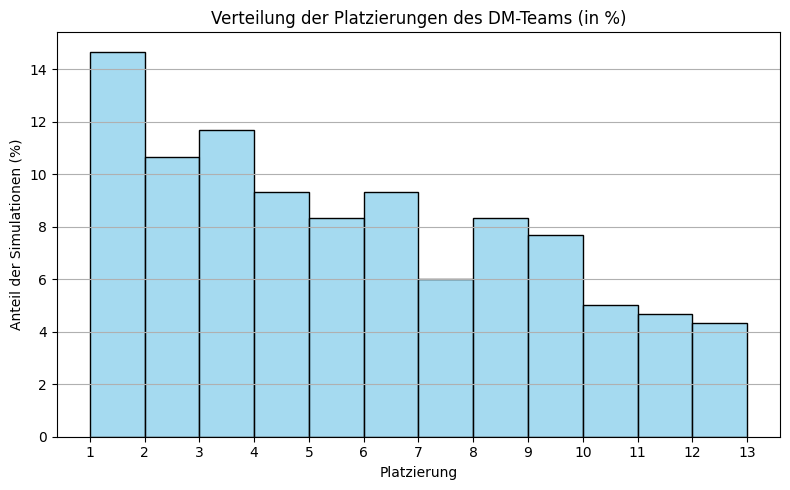

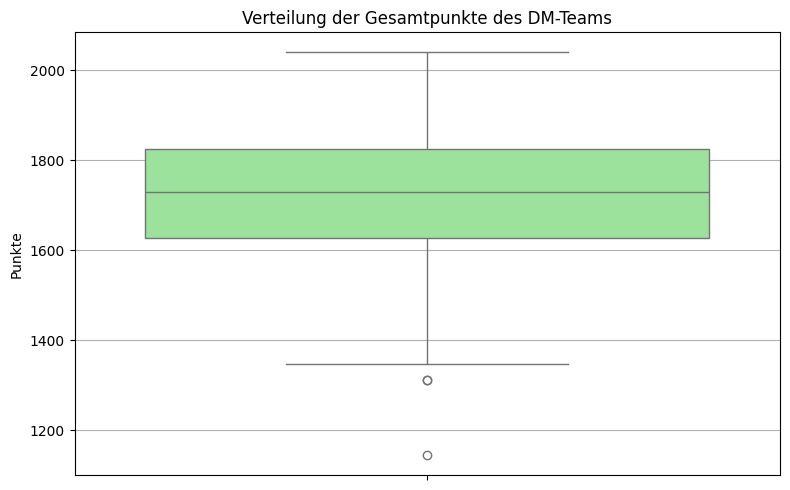

/tmp/ipython-input-29-1422835685.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dm_wins.index.map({True: "Gewonnen", False: "Nicht gewonnen"}), y=dm_wins.values, palette='pastel')


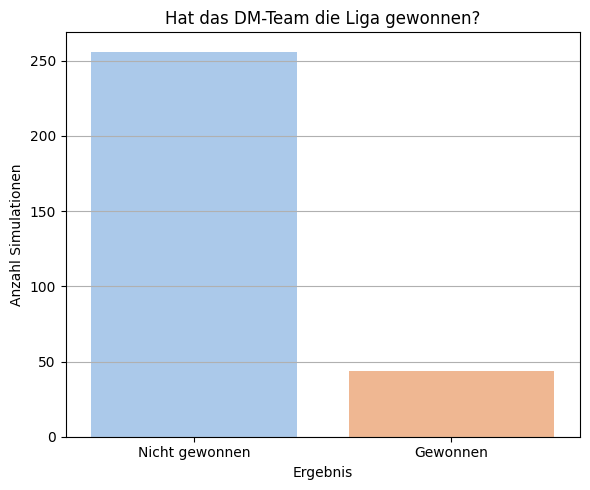

/tmp/ipython-input-29-1422835685.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_all, x="Winner", order=df_all["Winner"].value_counts().index, palette='muted')


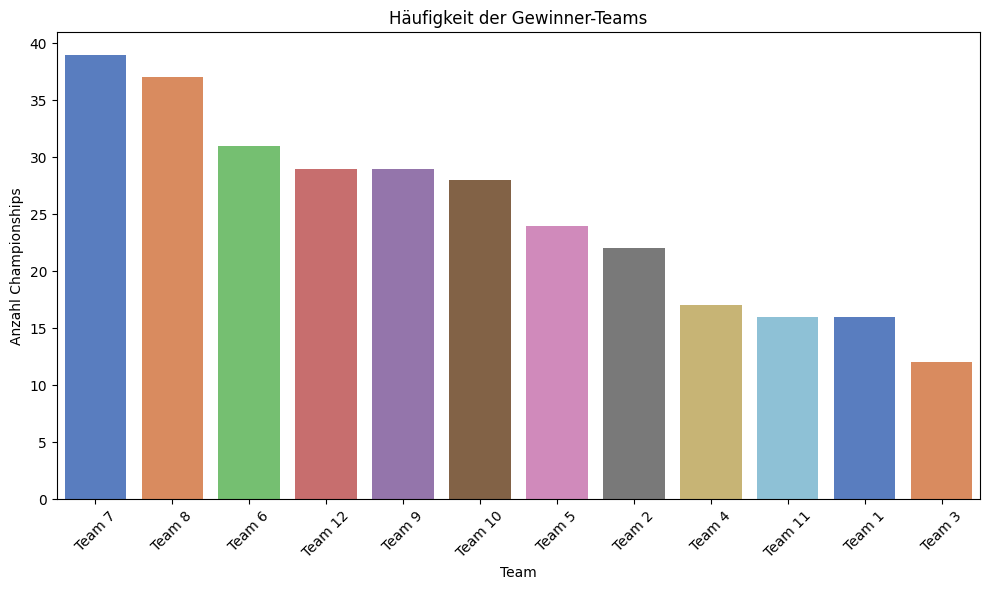

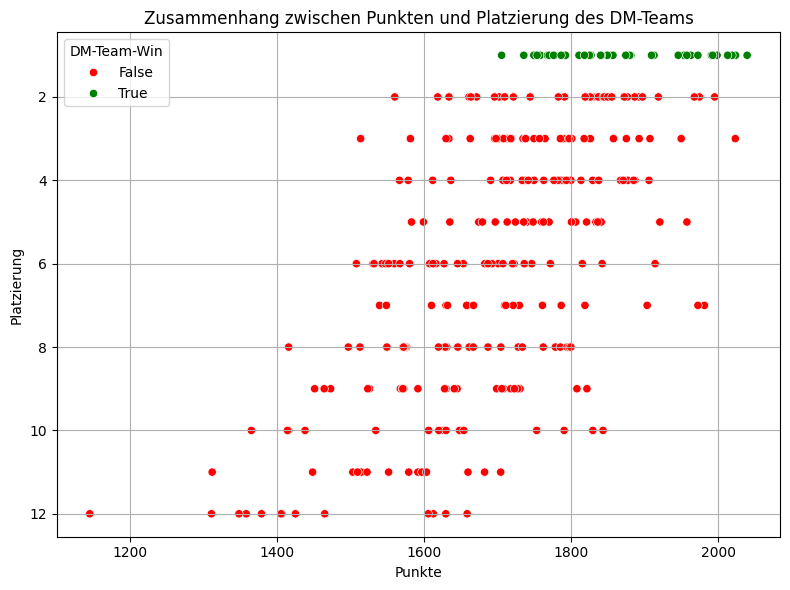

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Histogramm der Platzierungen des DM-Teams mit relativen Häufigkeiten (Prozent)
plt.figure(figsize=(8, 5))
sns.histplot(df_all["DM-Placement"], bins=range(1, 14), stat="percent", kde=False, color='skyblue')
plt.title("Verteilung der Platzierungen des DM-Teams (in %)")
plt.xlabel("Platzierung")
plt.ylabel("Anteil der Simulationen (%)")
plt.xticks(range(1, 14))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Plot 2: Boxplot der Punkte des DM-Teams
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_all["DM-Points"], color='lightgreen')
plt.title("Verteilung der Gesamtpunkte des DM-Teams")
plt.ylabel("Punkte")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot 3: Anzahl gewonnener Ligen durch das DM-Team
dm_wins = df_all["DM-Team-Win"].value_counts()
plt.figure(figsize=(6, 5))
sns.barplot(x=dm_wins.index.map({True: "Gewonnen", False: "Nicht gewonnen"}), y=dm_wins.values, palette='pastel')
plt.title("Hat das DM-Team die Liga gewonnen?")
plt.ylabel("Anzahl Simulationen")
plt.xlabel("Ergebnis")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot 4: Häufigkeit der Champion-Teams
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all, x="Winner", order=df_all["Winner"].value_counts().index, palette='muted')
plt.title("Häufigkeit der Gewinner-Teams")
plt.xlabel("Team")
plt.ylabel("Anzahl Championships")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 5: Punkte vs. Platzierung des DM-Teams
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_all, x="DM-Points", y="DM-Placement", hue="DM-Team-Win", palette={True: "green", False: "red"})
plt.title("Zusammenhang zwischen Punkten und Platzierung des DM-Teams")
plt.xlabel("Punkte")
plt.ylabel("Platzierung")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
